In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import metrics

nastavení

In [3]:
graf_priprava_dat = False

df_path = fr"C:\Users\halik\OneDrive\Dokumenty\GitHub\predikce-nabidky\production code\production dataset.xlsx"#@ cesta k datasetu

#@ externi regresory arima modelu
external_regressor_columns = ["nove-1", "zbytek-1"]
#@ promenne pouzite v modelu ktere potrebuji detrendovat, deseasonalizovat...
parametry = ['aktivni-1', *external_regressor_columns] 

#@ hyperparametry ARIMY 
p = 2  # AR myslim si ze by to melo byt 2 aby nebyl overfitting protoze pacf hodne spadne po lag=2
d = 1  # I 
q = 2  # MA


import dat

In [8]:

#@ args:
    # remove_first: odstrani prvních remove first řádků z datasetu (protože nejsou kompletni...)
    # remove_last: odstrani posledni remove_last řádků proto z data setu 
        # default = 6 (momentalne je poslednich 1 radku na predikce)
def get_df(remove_first = 0, remove_last = 1):
    df = pd.read_excel(df_path)
    df = df.drop(df.index[:remove_first])
    if remove_last != 0:
        df = df.drop(df.index[-remove_last:])
    #df['datetime'] = pd.date_range(start='2016-02-01', periods=len(df.index.values), freq='MS')
    return df
df = get_df(remove_first=12)

detrendování dat

In [5]:
#
#df = get_df(remove_first=12)
#
#columns = df.columns.tolist()
#columns.remove('datum')
#
#df_detrend = df.copy()
#for column in columns:
#    detrended = df[column] - df[column].rolling(window=2).mean()  #@window size nastudovat, upravit
#    df_detrend[column] = detrended
#
#df_detrend = df_detrend[1:]
#plt.plot(df.index, df['aktivni'], label='Original')
#plt.plot(df_detrend.index, df_detrend['aktivni'], label='Detrended')
#plt.legend()
#plt.show()

deseasonalizace dat

In [6]:
#df_deseasoned = df_detrend.copy()
#for column in columns:
#    decomp = sm.tsa.seasonal_decompose(df_detrend[parametr], period=12, model='additive')
#    df_deseasoned[parametr] = df_detrend[parametr] - decomp.seasonal.values
#    
#plt.plot(df_detrend.index, df_detrend['aktivni'])
#plt.plot(df_deseasoned.index, df_deseasoned['aktivni'])

arima modely

In [34]:
#! SMAZAT NA DEBUGING
import warnings
warnings.filterwarnings("ignore")

#df_arima = df_deseasoned
df_arima = df

target = df_arima['aktivni']
external_regressor_list = ['zbytek-1']
external_regressor = df_arima[[*external_regressor_list]]

#display(df_arima)
p_list = [2,3,4]
d_list = [1,2,5]
q_list = [0,1,2,5]
for p in tqdm(p_list):
    best_score = 100000000000000000000
    for d in d_list:
        for q in q_list:
            if not p+q > len(target)/10:
                model = ARIMA(target, order=(p, d, q), exog= external_regressor)
                model_fit = model.fit()
                aic = model_fit.aic
                aicc = model_fit.aicc
                bic = model_fit.bic
                score = aic+aicc+bic
            if score < best_score:
                best_score = score
                best_model = model_fit
#print(f"AIC: {aic}")
#print(f"AICC: {aicc}")
#print(f"BIC: {bic}")
print(best_model.summary())

100%|██████████| 3/3 [00:05<00:00,  1.80s/it]

                               SARIMAX Results                                
Dep. Variable:                aktivni   No. Observations:                   86
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -646.908
Date:                Thu, 31 Aug 2023   AIC                           1307.815
Time:                        12:35:39   BIC                           1324.831
Sample:                             0   HQIC                          1314.655
                                 - 86                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
zbytek-1      -0.0760      0.147     -0.518      0.604      -0.363       0.211
ar.L1         -0.0949      0.183     -0.517      0.605      -0.454       0.265
ar.L2          0.0454      0.139      0.326      0.7


MAE: 595.0822419112204
MSE: 556482.0314601609
RMSE: 745.9772325347208



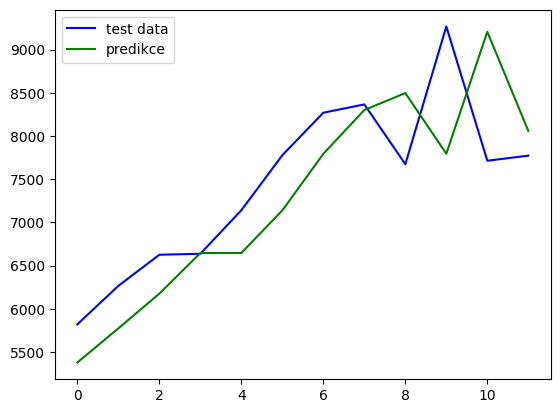

                               SARIMAX Results                                
Dep. Variable:                aktivni   No. Observations:                   85
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -639.642
Date:                Thu, 31 Aug 2023   AIC                           1293.285
Time:                        12:36:59   BIC                           1310.217
Sample:                             0   HQIC                          1300.087
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
zbytek-1      -0.0872      0.158     -0.550      0.582      -0.398       0.223
ar.L1         -0.0944      0.183     -0.514      0.607      -0.454       0.265
ar.L2          0.0610      0.139      0.440      0.6

In [38]:
pred_list = []
df_test = df_arima[-12:]

p = 4
d = 2
q = 1




for i in range(len(df_test)):
    df_train = df_arima[:-12+i]
    df_test_pred = df_arima.iloc[-12+i]
    model = ARIMA(df_train['aktivni'], order=(p, d, q), exog=df_train['zbytek-1'])
    model_fit = model.fit()
    pred = model_fit.forecast(steps=1, exog=[df_test_pred['zbytek-1']])
    pred_list.append(pred)


mae = mean_absolute_error(df_test['aktivni'], pred_list)
mse = mean_squared_error(df_test['aktivni'], pred_list, squared=True)
rmse = mean_squared_error(df_test['aktivni'], pred_list, squared=False)

print(f"""
MAE: {mae}
MSE: {mse}
RMSE: {rmse}
""")

plt.plot(range(len(df_test)), df_test['aktivni'], color="blue", label="test data")
plt.plot(range(len(pred_list)), pred_list, color='green', label='predikce')
plt.legend()
plt.show()

print(model_fit.summary())

In [ ]:
df_new = get_df(remove_last = 0) # 0 protze nechci odebrat radky co predpovidam
df_new = df_new.drop(df_new.index[0:-1])
df_pred = model_fit.forecast(exog=df_new[[*external_regressor_list]])
print(f"predikce na dalsi mesic ({int(df_new['datum'])}) je {int(df_pred)} bytu v nabidce")

predikce na dalsi mesic (202304) je 7995 bytu v nabidce


    rolling window forecast

distribuce

In [ ]:
from email.message import EmailMessage
import ssl
import smtplib
import os
import json
#@params

#* Load credentials from config.json
with open('config.json') as config_file:
    config_data = json.load(config_file)

email_user = config_data['email_user']
email_password = config_data['email_password']
email_recievers = config_data['email_recievers']

subject = "predikce nabidky"
email_body = f"""
predikce na dalsi mesic ({str(int(df_new['datum']))[4:]},{str(int(df_new['datum']))[:4]}) je {str(int(df_pred))} bytu v nabidce
"""

def send_mail(email_body):
    odeslat = False
    if odeslat:
        try:
            server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
            server.ehlo()
            server.login(email_user, email_password)
            server.sendmail(email_user, email_recievers, email_text)
            server.close()
            print('Email odeslán! SIIIUUUU')
        except Exception as exception:
            print("Error: %s!\n\n" % exception)
    else:
        print(email_body)
send_mail(email_body)


predikce na dalsi mesic (04,2023) je 8026 bytu v nabidce

